In [1]:
import pandas as pd
import numpy as np
import datetime
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import plotly.express as px

In [2]:
df = pd.read_csv('pick_pack_TBN1.csv')
df['day'] = pd.to_datetime(df['day'])
df.sort_values(by='day', inplace=True)

In [3]:
df[['warehouse', 'day_type']] = df[['warehouse', 'day_type']].astype('category')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['datetime'] = ( pd.to_datetime(df['day'])  + pd.to_timedelta(df['hour'], unit='h'))
df = df.drop(columns=['day', 'hour'])

# 2) Create item_id before one-hot
df['item_id'] = df['warehouse'].astype(str) + '_' + df['day_type'].astype(str)

# # 3) One-hot encode
df_encoded = pd.get_dummies(df, columns=['warehouse', 'day_type'], drop_first=True)

In [4]:
test_data = df_encoded[df_encoded['datetime'] >= '2025-05-10 00:00:00']
train_data = df_encoded[df_encoded['datetime'] < '2025-05-10 00:00:00']

In [5]:
# Lọc train_data chỉ lấy giờ từ 5 đến 22
train_data_filtered = train_data[
    (train_data['datetime'].dt.hour >= 5) & (train_data['datetime'].dt.hour <= 23)
]

# Tạo lại train_ts từ dữ liệu đã lọc
train_ts = TimeSeriesDataFrame.from_data_frame(
    train_data_filtered,
    id_column="item_id",
    timestamp_column="datetime",
)

test_ts = TimeSeriesDataFrame.from_data_frame(
    test_data,
    id_column="item_id",
    timestamp_column="datetime",
)

In [6]:
# # Train model trên train_ts đã lọc
# predictor_pack = TimeSeriesPredictor(
#     label='count_pack',
#     prediction_length=24,
#     freq='H',
#     eval_metric='WQL',
#     quantile_levels=[0.1, 0.5, 0.9],
#     verbosity=4,
#     path="Autogluon_Pack_avg",
# ).fit(train_data=train_ts, presets='best_quality', time_limit=7200)

# predictor_pick = TimeSeriesPredictor(
#     label='count_pick',
#     prediction_length=24,
#     freq='H',
#     eval_metric='WQL',
#     quantile_levels=[0.1, 0.5, 0.9],
#     verbosity=4,
#     path="Autogluon_Pick_avg",
# ).fit(train_data=train_ts, presets='best_quality', time_limit=7200)


In [7]:
prediction_pack = TimeSeriesPredictor.load("Autogluon_Pack_avg")
prediction_pick = TimeSeriesPredictor.load("Autogluon_Pick_avg")

pred_pack_ts = prediction_pack.predict(train_ts, random_seed=42, model='NPTS')
pred_pick_ts = prediction_pick.predict(train_ts, random_seed=42, model='NPTS')

data with frequency 'IRREG' has been resampled to frequency 'h'.
data with frequency 'IRREG' has been resampled to frequency 'h'.


In [8]:
print(prediction_pack.evaluate(train_ts))
print(prediction_pick.evaluate(train_ts))

data with frequency 'IRREG' has been resampled to frequency 'h'.
c:\Users\minh.bui1\AppData\Local\anaconda3\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attribute instead.
  warnings.warn(
data with frequency 'IRREG' has been resampled to frequency 'h'.


{'WQL': -0.08966144356758443}
{'WQL': -0.15904941402165781}


c:\Users\minh.bui1\AppData\Local\anaconda3\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attribute instead.
  warnings.warn(


data with frequency 'IRREG' has been resampled to frequency 'h'.


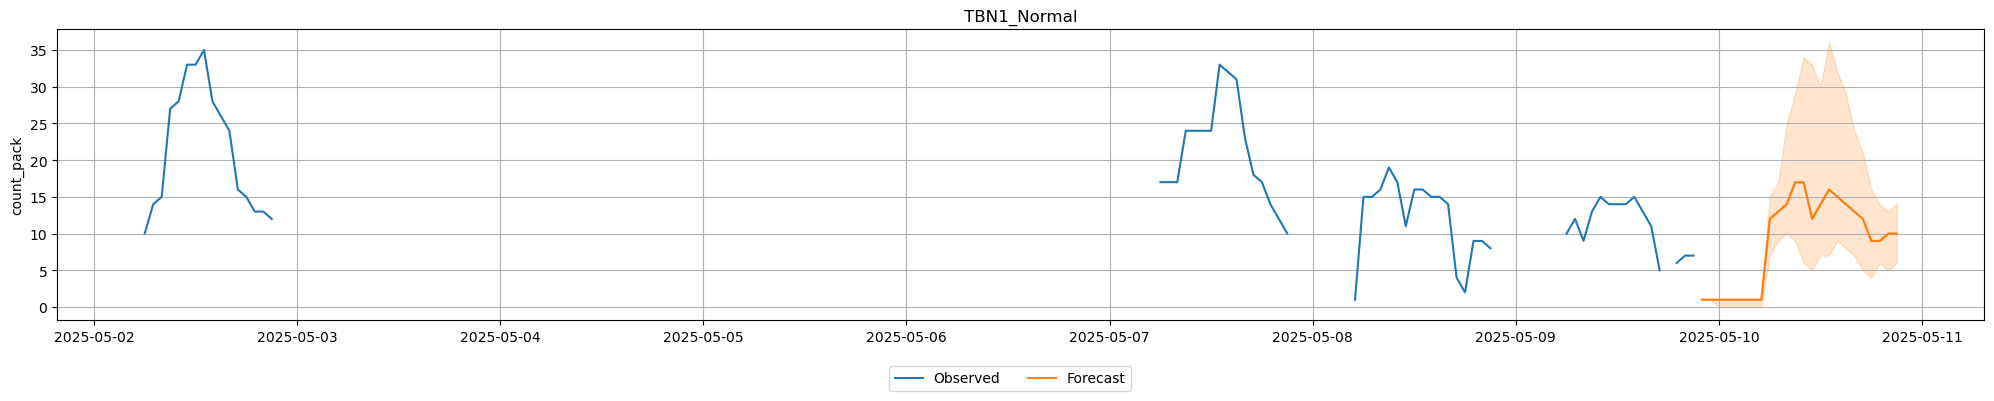

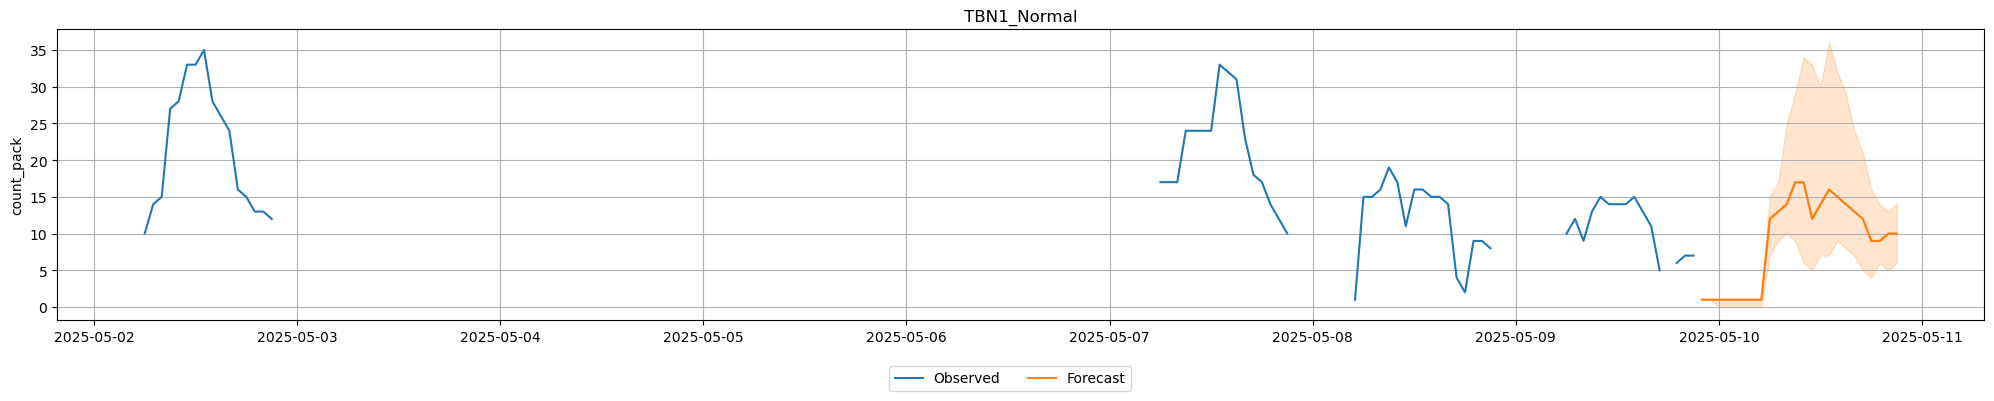

In [9]:
prediction_pack.plot(
    train_ts[['count_pack']],
    pred_pack_ts,
    quantile_levels=[0.1, 0.5, 0.9],
    max_history_length=200,
    max_num_item_ids=16
)

data with frequency 'IRREG' has been resampled to frequency 'h'.


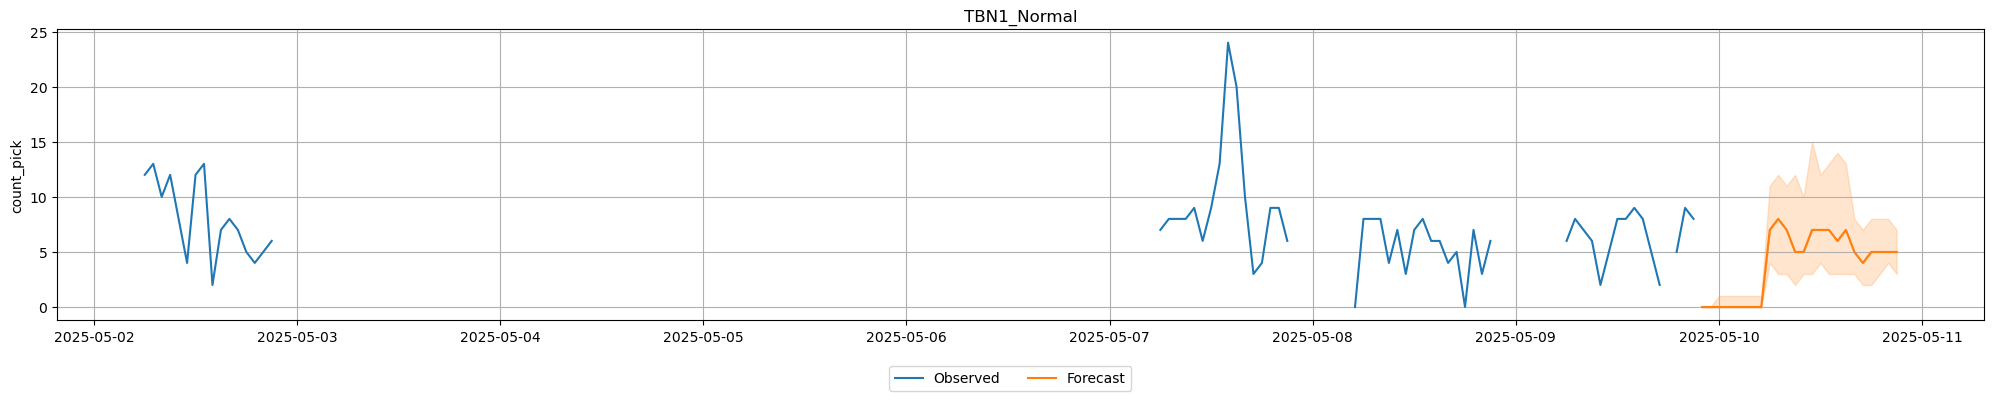

In [10]:
prediction_pick.plot(
    train_ts[['count_pick']],
    pred_pick_ts,
    quantile_levels=[0.1, 0.5, 0.9],
    max_history_length=200,
    max_num_item_ids=16
)

### Evaluation 

In [11]:
# Lấy giá trị dự đoán 0.9 từ pred_pack_ts và giá trị thực tế count_pack từ test_ts
pred_09_pack = pred_pack_ts['0.9'].apply(np.ceil)
pred_05_pack = pred_pack_ts['0.5'].apply(np.ceil)
pred_10_pack = pred_pack_ts['0.1'].apply(np.ceil)

actual = test_ts['count_pack']

# Gộp hai Series theo index (item_id, timestamp)
df_compare_pack = pd.DataFrame({'pred_09': pred_09_pack,  'pred_05': pred_05_pack, 'pred_10': pred_10_pack, 'actual': actual}).dropna()

df_compare_pack['ratio_09'] =df_compare_pack['pred_09'] / df_compare_pack['actual']
df_compare_pack['ratio_05'] = df_compare_pack['pred_05'] / df_compare_pack['actual']
df_compare_pack['ratio_10'] = df_compare_pack['pred_10'] / df_compare_pack['actual']

# Tính tỷ lệ
df_compare_pack['ratio_loss_09'] =((df_compare_pack['pred_09'] - df_compare_pack['actual']) / df_compare_pack['actual']).abs()
df_compare_pack['ratio_loss_05'] = ((df_compare_pack['pred_05'] - df_compare_pack['actual']) / df_compare_pack['actual']).abs()
df_compare_pack['ratio_loss_10'] = ((df_compare_pack['pred_10'] - df_compare_pack['actual']) / df_compare_pack['actual']).abs()

# Hiển thị kết quả
df_compare_pack.head(100)

pred_09  pred_05  pred_10  actual  ratio_09  \
item_id     timestamp                                                          
TBN1_Normal 2025-05-10 06:00:00     15.0     12.0      7.0    12.0  1.250000   
            2025-05-10 07:00:00     17.0     13.0      9.0    15.0  1.133333   
            2025-05-10 08:00:00     25.0     14.0     10.0    19.0  1.315789   
            2025-05-10 09:00:00     29.0     17.0      9.0    26.0  1.115385   
            2025-05-10 10:00:00     34.0     17.0      6.0    26.0  1.307692   
            2025-05-10 11:00:00     33.0     12.0      5.0    26.0  1.269231   
            2025-05-10 12:00:00     30.0     14.0      7.0    24.0  1.250000   
            2025-05-10 13:00:00     36.0     16.0      7.0    27.0  1.333333   
            2025-05-10 14:00:00     32.0     15.0      9.0    19.0  1.684211   
            2025-05-10 15:00:00     29.0     14.0      8.0    20.0  1.450000   
            2025-05-10 16:00:00     24.0     13.0      7.0    22.0  1.090909   
            2025-05-10 17:00:00     21.0     12.0      5.0    20.0  1.050000   
            2025-05-10 18:00:00     16.0      9.0      4.0    18.0  0.888889   
            2025-05-10 19:00:00     14.0      9.0      6.0    10.0  1.400000   
            2025-05-10 20:00:00     13.0     10.0      5.0    10.0  1.300000   
            2025-05-10 21:00:00     14.0     10.0      6.0     9.0  1.555556   

                                 ratio_05  ratio_10  ratio_loss_09  \
item_id     timestamp                                                
TBN1_Normal 2025-05-10 06:00:00  1.000000  0.583333       0.250000   
            2025-05-10 07:00:00  0.866667  0.600000       0.133333   
            2025-05-10 08:00:00  0.736842  0.526316       0.315789   
            2025-05-10 09:00:00  0.653846  0.346154       0.115385   
            2025-05-10 10:00:00  0.653846  0.230769       0.307692   
            2025-05-10 11:00:00  0.461538  0.192308       0.269231   
            2025-05-10 12:00:00  0.583333  0.291667       0.250000   
            2025-05-10 13:00:00  0.592593  0.259259       0.333333   
            2025-05-10 14:00:00  0.789474  0.473684       0.684211   
            2025-05-10 15:00:00  0.700000  0.400000       0.450000   
            2025-05-10 16:00:00  0.590909  0.318182       0.090909   
            2025-05-10 17:00:00  0.600000  0.250000       0.050000   
            2025-05-10 18:00:00  0.500000  0.222222       0.111111   
            2025-05-10 19:00:00  0.900000  0.600000       0.400000   
            2025-05-10 20:00:00  1.000000  0.500000       0.300000   
            2025-05-10 21:00:00  1.111111  0.666667       0.555556   

                                 ratio_loss_05  ratio_loss_10  
item_id     timestamp                                          
TBN1_Normal 2025-05-10 06:00:00       0.000000       0.416667  
            2025-05-10 07:00:00       0.133333       0.400000  
            2025-05-10 08:00:00       0.263158       0.473684  
            2025-05-10 09:00:00       0.346154       0.653846  
            2025-05-10 10:00:00       0.346154       0.769231  
            2025-05-10 11:00:00       0.538462       0.807692  
            2025-05-10 12:00:00       0.416667       0.708333  
            2025-05-10 13:00:00       0.407407       0.740741  
            2025-05-10 14:00:00       0.210526       0.526316  
            2025-05-10 15:00:00       0.300000       0.600000  
            2025-05-10 16:00:00       0.409091       0.681818  
            2025-05-10 17:00:00       0.400000       0.750000  
            2025-05-10 18:00:00       0.500000       0.777778  
            2025-05-10 19:00:00       0.100000       0.400000  
            2025-05-10 20:00:00       0.000000       0.500000  
            2025-05-10 21:00:00       0.111111       0.333333

In [12]:
# Lấy giá trị dự đoán 0.9 từ pred_pack_ts và giá trị thực tế count_pack từ test_ts
pred_09_pick = pred_pick_ts['0.9'].apply(np.ceil)
pred_05_pick = pred_pick_ts['0.5'].apply(np.ceil)
pred_10_pick = pred_pick_ts['0.1'].apply(np.ceil)

actual = test_ts['count_pack']

df_compare_pick = pd.DataFrame({'pred_09': pred_09_pick,  'pred_05': pred_05_pick, 'pred_10': pred_10_pick, 'actual': actual}).dropna()

df_compare_pick['ratio_09'] =df_compare_pick['pred_09'] / df_compare_pick['actual']
df_compare_pick['ratio_05'] = df_compare_pick['pred_05'] / df_compare_pick['actual']
df_compare_pick['ratio_10'] = df_compare_pick['pred_10'] / df_compare_pick['actual']

df_compare_pick['ratio_loss_09'] = ((df_compare_pick['pred_09'] - df_compare_pick['actual']) / df_compare_pick['actual']).abs()
df_compare_pick['ratio_loss_05'] = ((df_compare_pick['pred_05'] - df_compare_pick['actual']) / df_compare_pick['actual']).abs()
df_compare_pick['ratio_loss_10'] = ((df_compare_pick['pred_10'] - df_compare_pick['actual']) / df_compare_pick['actual']).abs()

# Hiển thị kết quả
df_compare_pick.head(100)

pred_09  pred_05  pred_10  actual  ratio_09  \
item_id     timestamp                                                          
TBN1_Normal 2025-05-10 06:00:00     11.0      7.0      4.0    12.0  0.916667   
            2025-05-10 07:00:00     12.0      8.0      3.0    15.0  0.800000   
            2025-05-10 08:00:00     11.0      7.0      3.0    19.0  0.578947   
            2025-05-10 09:00:00     12.0      5.0      2.0    26.0  0.461538   
            2025-05-10 10:00:00     10.0      5.0      3.0    26.0  0.384615   
            2025-05-10 11:00:00     15.0      7.0      3.0    26.0  0.576923   
            2025-05-10 12:00:00     12.0      7.0      4.0    24.0  0.500000   
            2025-05-10 13:00:00     13.0      7.0      3.0    27.0  0.481481   
            2025-05-10 14:00:00     14.0      6.0      3.0    19.0  0.736842   
            2025-05-10 15:00:00     13.0      7.0      3.0    20.0  0.650000   
            2025-05-10 16:00:00      8.0      5.0      3.0    22.0  0.363636   
            2025-05-10 17:00:00      7.0      4.0      2.0    20.0  0.350000   
            2025-05-10 18:00:00      8.0      5.0      2.0    18.0  0.444444   
            2025-05-10 19:00:00      8.0      5.0      3.0    10.0  0.800000   
            2025-05-10 20:00:00      8.0      5.0      4.0    10.0  0.800000   
            2025-05-10 21:00:00      7.0      5.0      3.0     9.0  0.777778   

                                 ratio_05  ratio_10  ratio_loss_09  \
item_id     timestamp                                                
TBN1_Normal 2025-05-10 06:00:00  0.583333  0.333333       0.083333   
            2025-05-10 07:00:00  0.533333  0.200000       0.200000   
            2025-05-10 08:00:00  0.368421  0.157895       0.421053   
            2025-05-10 09:00:00  0.192308  0.076923       0.538462   
            2025-05-10 10:00:00  0.192308  0.115385       0.615385   
            2025-05-10 11:00:00  0.269231  0.115385       0.423077   
            2025-05-10 12:00:00  0.291667  0.166667       0.500000   
            2025-05-10 13:00:00  0.259259  0.111111       0.518519   
            2025-05-10 14:00:00  0.315789  0.157895       0.263158   
            2025-05-10 15:00:00  0.350000  0.150000       0.350000   
            2025-05-10 16:00:00  0.227273  0.136364       0.636364   
            2025-05-10 17:00:00  0.200000  0.100000       0.650000   
            2025-05-10 18:00:00  0.277778  0.111111       0.555556   
            2025-05-10 19:00:00  0.500000  0.300000       0.200000   
            2025-05-10 20:00:00  0.500000  0.400000       0.200000   
            2025-05-10 21:00:00  0.555556  0.333333       0.222222   

                                 ratio_loss_05  ratio_loss_10  
item_id     timestamp                                          
TBN1_Normal 2025-05-10 06:00:00       0.416667       0.666667  
            2025-05-10 07:00:00       0.466667       0.800000  
            2025-05-10 08:00:00       0.631579       0.842105  
            2025-05-10 09:00:00       0.807692       0.923077  
            2025-05-10 10:00:00       0.807692       0.884615  
            2025-05-10 11:00:00       0.730769       0.884615  
            2025-05-10 12:00:00       0.708333       0.833333  
            2025-05-10 13:00:00       0.740741       0.888889  
            2025-05-10 14:00:00       0.684211       0.842105  
            2025-05-10 15:00:00       0.650000       0.850000  
            2025-05-10 16:00:00       0.772727       0.863636  
            2025-05-10 17:00:00       0.800000       0.900000  
            2025-05-10 18:00:00       0.722222       0.888889  
            2025-05-10 19:00:00       0.500000       0.700000  
            2025-05-10 20:00:00       0.500000       0.600000  
            2025-05-10 21:00:00       0.444444       0.666667

In [13]:
# Tạo dataframe FTE với tổng số pick và pack từ cột pred_05
FTE = pd.DataFrame({
    'pred_05_pack': df_compare_pack['pred_05'],
    'pred_05_pick': df_compare_pick['pred_05']
})
FTE['FTE_count'] = FTE['pred_05_pack'] + FTE['pred_05_pick']
FTE.head(100)

pred_05_pack  pred_05_pick  FTE_count
item_id     timestamp                                                 
TBN1_Normal 2025-05-10 06:00:00          12.0           7.0       19.0
            2025-05-10 07:00:00          13.0           8.0       21.0
            2025-05-10 08:00:00          14.0           7.0       21.0
            2025-05-10 09:00:00          17.0           5.0       22.0
            2025-05-10 10:00:00          17.0           5.0       22.0
            2025-05-10 11:00:00          12.0           7.0       19.0
            2025-05-10 12:00:00          14.0           7.0       21.0
            2025-05-10 13:00:00          16.0           7.0       23.0
            2025-05-10 14:00:00          15.0           6.0       21.0
            2025-05-10 15:00:00          14.0           7.0       21.0
            2025-05-10 16:00:00          13.0           5.0       18.0
            2025-05-10 17:00:00          12.0           4.0       16.0
            2025-05-10 18:00:00           9.0           5.0       14.0
            2025-05-10 19:00:00           9.0           5.0       14.0
            2025-05-10 20:00:00          10.0           5.0       15.0
            2025-05-10 21:00:00          10.0           5.0       15.0

In [14]:
# Định nghĩa shift và khung giờ
shift_map = {
    'TKN_CA 26': ('12:00:00', '20:00:00'),
    'TKN_CA 1':  ('06:00:00', '14:00:00'),
    'TKN_CA 34': ('14:00:00', '22:00:00'),
    'TKN_CA 30': ('13:00:00', '21:00:00'),
    'TKN_CA 53': ('08:00:00', '16:00:00'),
    'TKN_CA 13': ('09:00:00', '17:00:00'),
    'TKN_CA 25': ('11:30:00', '19:30:00'),
}

# Chuyển khung giờ sang datetime.time để so sánh
shift_times = {
    shift: (datetime.time.fromisoformat(start), datetime.time.fromisoformat(end))
    for shift, (start, end) in shift_map.items()
}

# Đảm bảo cột timestamp là kiểu datetime
FTE = FTE.reset_index()
FTE['timestamp'] = pd.to_datetime(FTE['timestamp'])

# Hàm xác định shift dựa vào thời gian
def assign_shift(ts):
    t = ts.time()
    for shift, (start, end) in shift_times.items():
        if start <= t < end:
            return shift
    return None

# Áp dụng hàm và gán shift
FTE['shift'] = FTE['timestamp'].apply(assign_shift)

# Tách ngày
FTE['date'] = FTE['timestamp'].dt.date

# Tổng hợp FTE_count theo item_id, date và shift
result = (
    FTE.dropna(subset=['shift'])
      .groupby(['item_id', 'date', 'shift'], as_index=False)['FTE_count']
      .max()
)

result.head(100)

,item_id,date,shift,FTE_count
0,TBN1_Normal,2025-05-10,TKN_CA 1,22.0
1,TBN1_Normal,2025-05-10,TKN_CA 26,23.0
2,TBN1_Normal,2025-05-10,TKN_CA 34,15.0
